### Constants

In [2]:
X = 0
Y = 1
DEF_CENTROID_SIZE = 2;
DEF_POINT_SIZE = 4;

PAUSE_TIME = 1;

INPUT_FILE_NAME = "testdata.csv"
X_ROW_NAME = "X"
Y_ROW_NAME = "Y"
PLOT_NAME = f"{X_ROW_NAME} vs {Y_ROW_NAME}"
DEF_CENTROID_SIZE = 2;

X = 0
Y = 1

# CENTROIDS = [(1, 1), (35, 1), (55, 1), ]
CENTROIDS = [(1, 1), (20, 1), (40, 1), (60, 1)]
# CENTROIDS = [(70, 100), (71, 101), (72, 102), (73, 103)]

COLOURS = ['red', 'green', 'blue', 'orange']
# COLOURS = ['red', 'green', 'blue']

LT_CENTROID_COLOUR = 'grey'
DK_CENTROID_COLOUR = 'black'

NEW_POINTS = 55
MIN_AGE = 45
MAX_AGE = 70
MIN_SCORE = 80
MAX_SCORE = 100

RECLUSTERING_THRESHOLD = .1

### Points class

In [3]:
import copy
from typing import Union

class Points:
    def __init__(self, points: list[(float, float)] = [], 
                 groups: list[str] = None, 
                 sqrd_distances: list[float] = None, 
                 alpha: list[float] = None,
                 sizes: list[float] = None, 
                 centroids: Union['Points', list[(float, float)]] = None, 
                 other_points: Union['Points', list[(float, float)]] = None):
        # set points
        self.points = copy.deepcopy(points)
        self.x = [point[X] for point in points]
        self.y = [point[Y] for point in points]

        self.count = len(points)

        # centroids, original_centroids and other_points are drawn, but removed from the calculations
        if type(centroids) == list: 
            self.centroids = Points.create_centroids(centroids)
        else:
            self.centroids = copy.deepcopy(centroids)
        self.other_points = copy.deepcopy(other_points)
 
        self.alpha = ([1] * self.count if alpha is None else alpha)
        self.sizes = ([DEF_POINT_SIZE] * self.count if sizes is None else sizes)

        if self.centroids is not None:
            # Sets original_centroids (stored seperately to calculate how much the centroid has moved)
            self.update_original_centroids()
            # Sets distances and groups
            self.assign_points_to_cluster()
            # Sets original cluster spread
            self.update_original_cluster_spread()
        else:
            self.sqrd_distances = ([0] * self.count if sqrd_distances is None else sqrd_distances)
            self.groups = ([DK_CENTROID_COLOUR] * self.count if groups is None else groups)        

    def append(self, point: tuple[float, float], group: str = None, size: float = DEF_POINT_SIZE, distance: float = None, alpha: float = 1):
        # add point
        self.points.append(point)
        self.x.append(point[X])
        self.y.append(point[Y])

        self.alpha.append(alpha)
        self.groups.append(group)
        self.sizes.append(size)
        self.sqrd_distances.append(distance)

        self.count += 1

    def remove_last(self):
        self.points.pop()
        self.x.pop()
        self.y.pop()

        self.alpha.pop()
        self.groups.pop()
        self.sizes.pop()
        self.sqrd_distances.pop()

        self.count -= 1

    def get_group_size(self, group_name: str) -> int:
        return sum(1 for group in self.groups if group == group_name)
    
    def remove_group(self, group_name: str):
        indeces_to_remove = [i for i, group in enumerate(self.groups) if group == group_name]
        
        for index in reversed(indeces_to_remove):
            self.points.pop(index)
            self.x.pop(index)
            self.y.pop(index)
            self.alpha.pop(index)
            self.sizes.pop(index)
            self.sqrd_distances.pop(index) 
            self.groups.pop(index)

        self.count -= len(indeces_to_remove)  

    def get_group_points(self, group_name: str) -> list[(float, float)]:
        group = [point for point, group in zip(self.points, self.groups) if group == group_name]
        return group
    
    def get_all_points(self):
        # Add points + other_points + original_centroids + centroids

        new_points_list = copy.deepcopy(self.points)                                                        # points
        new_points_list += (self.other_points.points if self.other_points is not None else [])              # other_points
        new_points_list += (self.original_centroids.points if self.original_centroids is not None else [])  # original_centroids
        new_points_list += (self.centroids.points if self.centroids is not None else [])                    # centroids

        new_alpha = copy.deepcopy(self.alpha)                                                               # points
        new_alpha += (self.other_points.alpha if self.other_points is not None else [])                     # other_points
        new_alpha += (self.original_centroids.alpha if self.original_centroids is not None else [])         # original_centroids
        new_alpha += (self.centroids.alpha if self.centroids is not None else [])                           # centroids
        
        new_groups = copy.deepcopy(self.groups)                                                             # points
        new_groups += (self.other_points.groups if self.other_points is not None else [])                   # other_points 
        new_groups += (self.original_centroids.groups if self.original_centroids is not None else [])       # original_centroids
        new_groups += (self.centroids.groups if self.centroids is not None else [])                         # centroids


        new_sizes = copy.deepcopy(self.sizes)                                                               # points
        new_sizes += (self.other_points.sizes if self.other_points is not None else [])                     # other_points
        new_sizes += (self.original_centroids.sizes if self.original_centroids is not None else [])         # original_centroids
        new_sizes += (self.centroids.sizes if self.centroids is not None else [])                           # centroids

        new_points = Points(new_points_list, new_groups, alpha=new_alpha, sizes=new_sizes)

        return new_points

    def create_centroids(centroids: list[float, float]) -> 'Points':
        cent_len = len(centroids)
        points = Points(centroids, groups=[DK_CENTROID_COLOUR] * cent_len, sizes = [DEF_CENTROID_SIZE] * cent_len)
        return points

    def get_cluster_spread(self, groups: list[str]) -> tuple[dict[str, int], dict[str, int]]:
        # calculate spread in added
        group_spread = {colour: 0 for colour in groups}
        group_count = {colour: 0 for colour in groups}
        total_distance = 0

        for i, colour in enumerate(groups):
            cur_group = self.get_group_points(colour)
            group_distance = 0
            if len(cur_group) != 0:
                group_distance = sum(Points._calculate_sqrd_distance(cur_point, self.centroids.points[i]) for cur_point in cur_group )
                group_spread[colour] = group_distance / len(cur_group)
                group_count[colour] = len(cur_group)
        
            total_distance += group_distance
        
        total_spread = total_distance / self.count

        group_spread['total'] = total_spread
        group_count['total'] = self.count

        return (group_spread, group_count)

    # If centroids is passed, set original_centroids to that. Otherwise set then to current centroids
    def update_original_centroids(self, centroids: 'Points' = None):
        if centroids is None:
            centroids = self.centroids

        self.original_centroids = copy.deepcopy(centroids)
        self.original_centroids.groups = [LT_CENTROID_COLOUR] * centroids.count
        self.original_centroids.alpha = [0.5] * centroids.count
    
    def update_original_cluster_spread(self):
        self.original_cluster_spread = self.get_cluster_spread(COLOURS)[0]

    # Assigns its all its points to the nearest cluster. Sets distance and groups
    def assign_points_to_cluster(self) -> tuple[list[str], list[float]]:
        groups = []
        distances = []

        for point in self.points:
            closest_centroid_index = min(
                enumerate(self.centroids.points),
                key = lambda x: Points._calculate_sqrd_distance(point, x[1])
            )[0]

            groups.append(COLOURS[closest_centroid_index])
            distances.append(Points._calculate_sqrd_distance(point, self.centroids.points[closest_centroid_index]))

        self.groups = groups
        self.sqrd_distances = distances

    def _calculate_sqrd_distance(point: tuple[float, float], centroid: tuple[float, float]) -> float:
        sqrd_distance = (centroid[X] - point[X]) ** 2 + (centroid[Y] - point[Y]) ** 2
        return sqrd_distance
 

### Commonly used functions

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import copy
import random


def generate_scatter_plot(points: Points, plot_name = 'plot'):        
    plt.clf()
    
    all_points = points.get_all_points()

    plt.title(plot_name)
    plt.xlabel(X_ROW_NAME)
    plt.ylabel(Y_ROW_NAME)
    plt.scatter(all_points.x, all_points.y, c=all_points.groups, s=all_points.sizes, alpha=all_points.alpha)

def show_scatter_plot(points: Points, plot_name = 'plot', block=True):
    generate_scatter_plot(points, plot_name)
    plt.show(block=block)
    plt.pause(PAUSE_TIME)

def save_scatter_plot(points: Points, plot_name = 'plot'):
    generate_scatter_plot(points, plot_name)
    plt.savefig(f'{plot_name}.png')    

def calculate_sqrd_distance(point: tuple[float, float], centroid: tuple[float, float]) -> float:
    sqrd_distance = (centroid[X] - point[X]) ** 2 + (centroid[Y] - point[Y]) ** 2
    return sqrd_distance

def get_points_from_file(file_name: str = INPUT_FILE_NAME) -> list[(float, float)]:
    print(f"Loading points from {file_name}...")

    df = pd.read_csv(file_name)

    points = [(row[X_ROW_NAME], row[Y_ROW_NAME]) for _, row in df.iterrows()]
    print(f"Finished loading points from {INPUT_FILE_NAME}.")
    return points

def get_cluster_means(points: list[(float, float)], point_groups: list[str], cluster_groups: list[str], centroids: list[(float, float)]) -> dict[str, float]:
    amount_dict = {group: (0, 0) for group in cluster_groups}
    count_dict = {group: 0 for group in cluster_groups}
    means = {group: 0 for group in cluster_groups}

    for i, cur_group in enumerate(point_groups):
        curX, curY = amount_dict[cur_group]
        newX = curX + points[i][X]
        newY = curY + points[i][Y]
        amount_dict[cur_group] = (newX, newY)
        
        count_dict[cur_group] = count_dict[cur_group] + 1
    
    j = 0
    for key, value in amount_dict.items():

        if count_dict[key] == 0:
            mean_x = centroids[j][X]
            mean_y = centroids[j][Y]
        else:
            mean_x = value[X]/ count_dict[key]
            mean_y = value[Y] / count_dict[key]
        means[key] = (mean_x, mean_y)

        j = j +1
    return means

def run_clustering_from_file(plot_name: str, starting_centroids: list[float, float], colours_groups: list[str], 
                             show: bool = False, save: bool = False) -> Points:
    points = Points(get_points_from_file(), centroids=starting_centroids)
    
    return run_clustering_from_points(plot_name, colours_groups, 
                                      points, show, save)

def run_clustering_from_points(plot_name: str, colours_groups: list[str], points: Points, show: bool = False, save: bool = False) -> Points:  
    old_means = None
    means = copy.deepcopy(points.centroids.points)
    points_clustered = copy.deepcopy(points)

    points_clustered.assign_points_to_cluster()

    if show:
        show_scatter_plot(points_clustered, f"{plot_name}-0", False)
    if save:
        save_scatter_plot(points_clustered, f"{plot_name}-0")

    i = 0
    while not old_means == means:
        i = i + 1

        old_means = means

        points_clustered.assign_points_to_cluster()

        means = list(get_cluster_means(points_clustered.points, points_clustered.groups, colours_groups, means).values())
        points_clustered.centroids = Points.create_centroids(means)


        if show:
            show_scatter_plot(points_clustered, f"{plot_name}-{i}", False)
        if save:
            save_scatter_plot(points_clustered, f"{plot_name}-{i}")

    return points_clustered

# Adds number_of_points to points. passed object is modified
def add_random_points(number_of_points: int, points: Points,
                      save: bool = False, show: bool = False, plot_name: str = 'plot', reclustering: bool = True):

    for i in range(number_of_points):
        cur_plot_name = f'{plot_name}-{i}'
        # generate new point
        if show:
            print(f"Generating point {i}")
        new_point = (random.randint(MIN_AGE, MAX_AGE), random.randint(MIN_SCORE, MAX_SCORE))

        # add new point to graph
        if show or save:
            points.append(new_point, group='yellow', size=1000, alpha=.5)
            points.append(new_point, group='black')
            if show:
                show_scatter_plot(points, block=False, plot_name=cur_plot_name)
            if save:
                save_scatter_plot(points, plot_name=cur_plot_name)

            points.remove_last()
            points.remove_last()

        # assign point to a new cluster
        closest_centroid_index = min(
                enumerate(points.centroids.points),
                key = lambda x: calculate_sqrd_distance(new_point, x[1])
            )[0]

        new_point_cluster = COLOURS[closest_centroid_index]
        
        points.append(new_point, new_point_cluster)
        if show:
            show_scatter_plot(points, block=False, plot_name=cur_plot_name)
        if save:
            save_scatter_plot(points, plot_name=cur_plot_name)

            
        # move centroid
        cluster_size = points.get_group_size(new_point_cluster)
        centroid_index = COLOURS.index(new_point_cluster)
        new_centroid_x = (cluster_size * points.centroids.points[centroid_index][X] + new_point[X]) / (cluster_size + 1)
        new_centroid_y = (cluster_size * points.centroids.points[centroid_index][Y] + new_point[Y]) / (cluster_size + 1)
        points.centroids.points[centroid_index] = (new_centroid_x, new_centroid_y)

        if show:
            show_scatter_plot(points, block=False, plot_name=cur_plot_name)
        if save:
            points.append(new_point, group='yellow', size=1000, alpha=.5)
            save_scatter_plot(points, plot_name=cur_plot_name)
            points.remove_last()

        if reclustering:
            group_spread = points.original_cluster_spread
            total_move_ratio = 0
            for j, colour in enumerate(COLOURS):
                cur_cent = points.centroids.points[j]
                cur_cent_og = points.original_centroids.points[j]

                dist_cur_cent_moved = calculate_sqrd_distance(cur_cent, cur_cent_og)
                total_move_ratio += dist_cur_cent_moved / group_spread[colour]
            
            print(f"Total move ratio: {total_move_ratio}")
            if total_move_ratio >= RECLUSTERING_THRESHOLD:
                print("Time to recluster")
                points.centroids = Points.create_centroids(CENTROIDS)
                points = run_clustering_from_points(f"{cur_plot_name} - R", COLOURS, points, show=show, save=save)
                points.update_original_cluster_spread()
                points.update_original_centroids()
    
    return points

# Adds point to points with potential reclustring
def add_point(new_point: tuple[float, float], points: Points,
                      save: bool = False, show: bool = False, plot_name: str = 'plot', reclustering: bool = True):
    # add new point to graph
    if show or save:
        points.append(new_point, group='yellow', size=1000, alpha=.5)
        points.append(new_point, group='black')
        if show:
            show_scatter_plot(points, block=False, plot_name=plot_name)
        if save:
            save_scatter_plot(points, plot_name=plot_name)

        points.remove_last()
        points.remove_last()

    # assign point to a new cluster
    closest_centroid_index = min(
            enumerate(points.centroids.points),
            key = lambda x: calculate_sqrd_distance(new_point, x[1])
        )[0]

    new_point_cluster = COLOURS[closest_centroid_index]
    
    points.append(new_point, new_point_cluster)
    if show:
        show_scatter_plot(points, block=False, plot_name=plot_name)
    if save:
        save_scatter_plot(points, plot_name=plot_name)

        
    # move centroid
    cluster_size = points.get_group_size(new_point_cluster)
    centroid_index = COLOURS.index(new_point_cluster)
    new_centroid_x = (cluster_size * points.centroids.points[centroid_index][X] + new_point[X]) / (cluster_size + 1)
    new_centroid_y = (cluster_size * points.centroids.points[centroid_index][Y] + new_point[Y]) / (cluster_size + 1)
    points.centroids.points[centroid_index] = (new_centroid_x, new_centroid_y)

    if show:
        show_scatter_plot(points, block=False, plot_name=plot_name)
    if save:
        points.append(new_point, group='yellow', size=1000, alpha=.5)
        save_scatter_plot(points, plot_name=plot_name)
        points.remove_last()

    if reclustering:
        group_spread = points.original_cluster_spread
        total_move_ratio = 0
        for j, colour in enumerate(COLOURS):
            cur_cent = points.centroids.points[j]
            cur_cent_og = points.original_centroids.points[j]

            dist_cur_cent_moved = calculate_sqrd_distance(cur_cent, cur_cent_og)

            total_move_ratio += dist_cur_cent_moved / group_spread[colour]
        
        # print(f"Total move ratio: {total_move_ratio}")
        if total_move_ratio >= RECLUSTERING_THRESHOLD:
            print("Time to recluster")
            points.centroids = Points.create_centroids(CENTROIDS)
            points = run_clustering_from_points(f"{plot_name} - R", COLOURS, points, show=show, save=save)
            points.update_original_cluster_spread()
            points.update_original_centroids()
    
    return points

### Experiment: Add Random Points
This was used for the presentation. The constants are not set for this to run.

In [ ]:
import time
import copy


# cluster from file
points = run_clustering_from_file(PLOT_NAME, CENTROIDS, COLOURS)
points.original_centroids = None
save_scatter_plot(points, plot_name='initial')

points_add = copy.deepcopy(points)
points_add.update_original_centroids() 
points_add.update_original_cluster_spread()
# points_add.other_points = Points([(0,0), (100, 0), (0, 100), (100, 100)])
points_add = add_random_points(NEW_POINTS, points_add, show = False, reclustering=True, save=True)

save_scatter_plot(points_add, plot_name='dynamic')

# recluster the new points
points_rerun = copy.deepcopy(points_add)
points_rerun.centroids = Points.create_centroids(CENTROIDS)
points_rerun.update_original_centroids()
points_rerun = run_clustering_from_points('regular', COLOURS, points_rerun, save = True, show=False)
points_rerun.original_centroids = None

save_scatter_plot(points_rerun, plot_name='regular')

# calculate spread in dynamic
group_spead_dynamic, group_count_dynamic = points_add.get_cluster_spread(COLOURS)

print("\nVariance of Dynamic:")
print(group_spead_dynamic)
print(group_count_dynamic)

# calculate spread in regular
group_spread_regular, group_count_regulat = points_rerun.get_cluster_spread(COLOURS)

print(f'\nVariance of Regular:')
print(group_spread_regular)
print(group_count_regulat)
print("end")

### Experiment: Speed Comparison

In [17]:
# Read the points from the file
new_points_lst = get_points_from_file("additionaldata.csv")

Loading points from additionaldata.csv...
Finished loading points from testdata.csv.


Loading points from testdata.csv...
Finished loading points from testdata.csv.
28064971.21906139


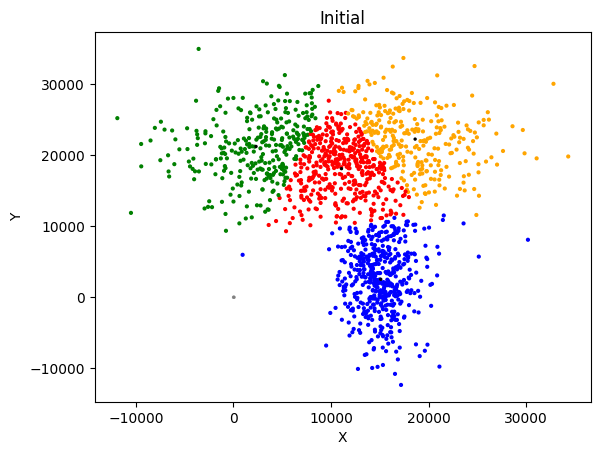

In [18]:
# Cluster initial points
points = run_clustering_from_file(PLOT_NAME, CENTROIDS, COLOURS, show=False, save=False)
save_scatter_plot(points, "Initial")
print(points.get_cluster_spread(COLOURS)[0]['total'])

Loading points from testdata.csv...
Finished loading points from testdata.csv.
Elapsed time:  12.698345 seconds


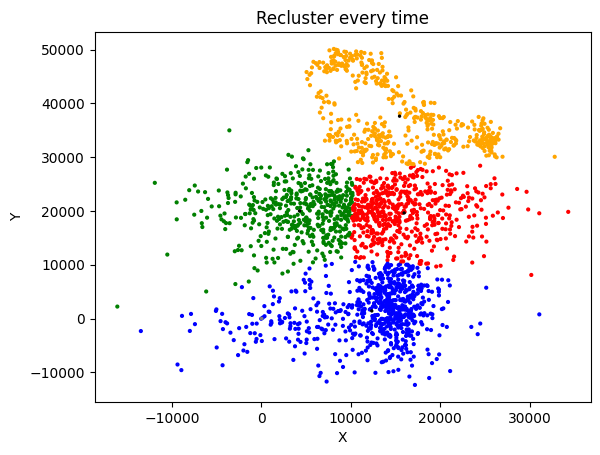

In [19]:
# Add new points and recluster every time
import time

points = run_clustering_from_file(PLOT_NAME, CENTROIDS, COLOURS, show=False, save=False)

start_time = time.perf_counter()
for index, point in enumerate(new_points_lst):
    points.append(point)
    points = run_clustering_from_points("NEW", COLOURS, points, show=False, save=False)
end_time = time.perf_counter()
print(f"Elapsed time: {end_time-start_time: .6f} seconds")

save_scatter_plot(points, "Recluster every time")


Loading points from testdata.csv...
Finished loading points from testdata.csv.


/var/folders/z4/lfpb3ghd2ljfqx08kqnzc7f00000gn/T/ipykernel_10377/3887907810.py:229: RuntimeWarning: divide by zero encountered in scalar divide
  total_move_ratio += dist_cur_cent_moved / group_spread[colour]


Time to recluster
Time to recluster
Time to recluster
Elapsed time:  0.352195 seconds


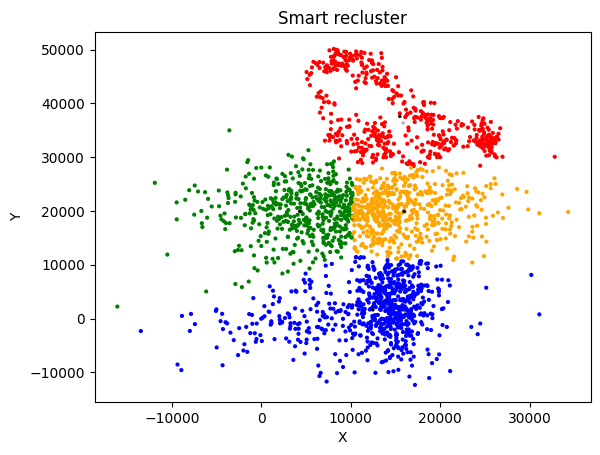

In [20]:
# Add new points and recluster only when needed
import time

points = run_clustering_from_file(PLOT_NAME, CENTROIDS, COLOURS, show=False, save=False)

start_time = time.perf_counter()
for index, point in enumerate(new_points_lst):
    points = add_point(point, points, save = False, show= False, reclustering=True)
end_time = time.perf_counter()
print(f"Elapsed time: {end_time-start_time: .6f} seconds")

save_scatter_plot(points, "Smart recluster")


Loading points from testdata.csv...
Finished loading points from testdata.csv.
Elapsed time:  0.024202 seconds


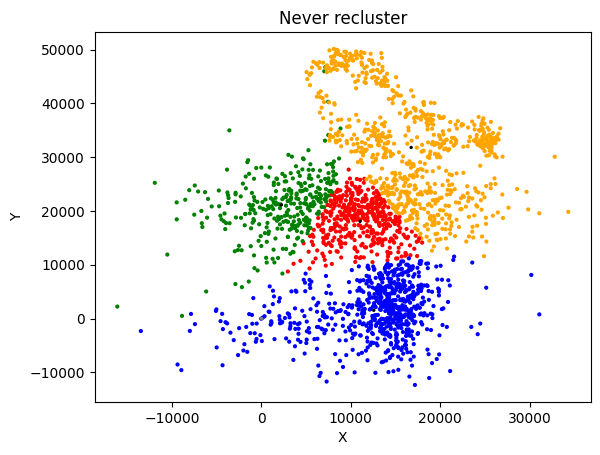

In [21]:
# Add new points and never recluster
import time

points = run_clustering_from_file(PLOT_NAME, CENTROIDS, COLOURS, show=False, save=False)

start_time = time.perf_counter()
for index, point in enumerate(new_points_lst):
    points = add_point(point, points, save = False, show= False, reclustering=False)
end_time = time.perf_counter()
print(f"Elapsed time: {end_time-start_time: .6f} seconds")

save_scatter_plot(points, "Never recluster")


### Experiment: Accuraccy Comparison

In [5]:
# Read the points from the file
new_points_lst = get_points_from_file("additionaldata.csv")

Loading points from additionaldata.csv...
Finished loading points from testdata.csv.


Loading points from testdata.csv...
Finished loading points from testdata.csv.


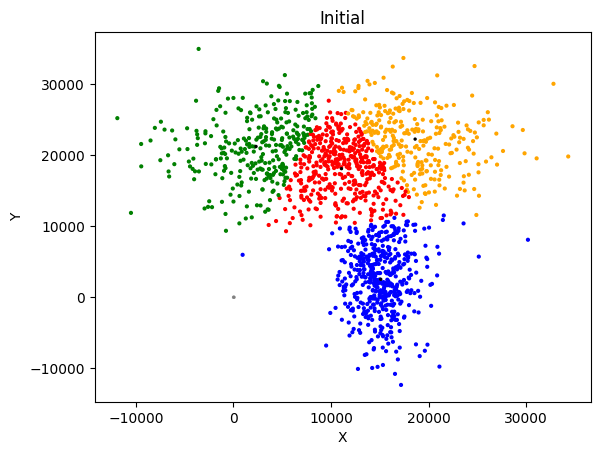

In [ ]:
# Cluster initial points
points = run_clustering_from_file(PLOT_NAME, CENTROIDS, COLOURS, show=False, save=False)
save_scatter_plot(points, "Initial")
initial_var = points.get_cluster_spread(COLOURS)[0]['total']

Loading points from testdata.csv...
Finished loading points from testdata.csv.


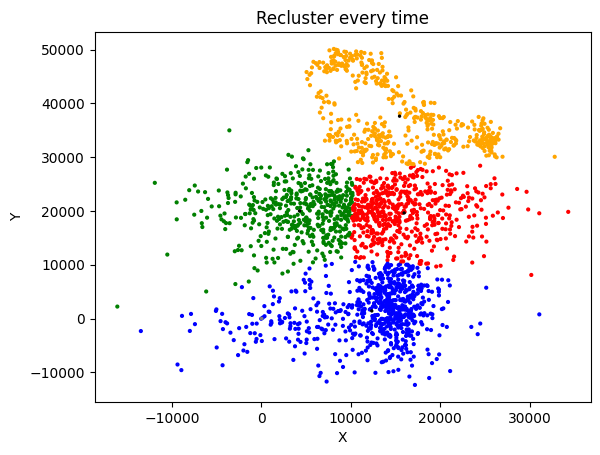

In [ ]:
# Add new points and recluster every time
points = run_clustering_from_file(PLOT_NAME, CENTROIDS, COLOURS, show=False, save=False)
recluster_var = []

for index, point in enumerate(new_points_lst):
    points.append(point)
    points = run_clustering_from_points("NEW", COLOURS, points, show=False, save=False)
    recluster_var.append(points.get_cluster_spread(COLOURS)[0]['total'])

save_scatter_plot(points, "Recluster every time")


Loading points from testdata.csv...
Finished loading points from testdata.csv.


/var/folders/z4/lfpb3ghd2ljfqx08kqnzc7f00000gn/T/ipykernel_10377/3887907810.py:229: RuntimeWarning: divide by zero encountered in scalar divide
  total_move_ratio += dist_cur_cent_moved / group_spread[colour]


Time to recluster
Reclustered at new point number 0
Time to recluster
Reclustered at new point number 60
Time to recluster
Reclustered at new point number 175


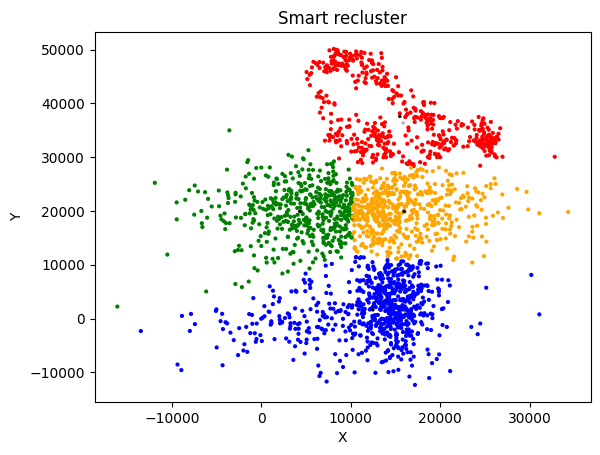

In [ ]:
# Add new points and recluster only when needed
points = run_clustering_from_file(PLOT_NAME, CENTROIDS, COLOURS, show=False, save=False)
smart_var = []

for index, point in enumerate(new_points_lst):
    new_points = add_point(point, points, save = False, show= False, reclustering=True)

    if (points != new_points):
        print(f"Reclustered at new point number {index}")
        points = new_points

    smart_var.append(points.get_cluster_spread(COLOURS)[0]['total'])

save_scatter_plot(points, "Smart Recluster")


Loading points from testdata.csv...
Finished loading points from testdata.csv.


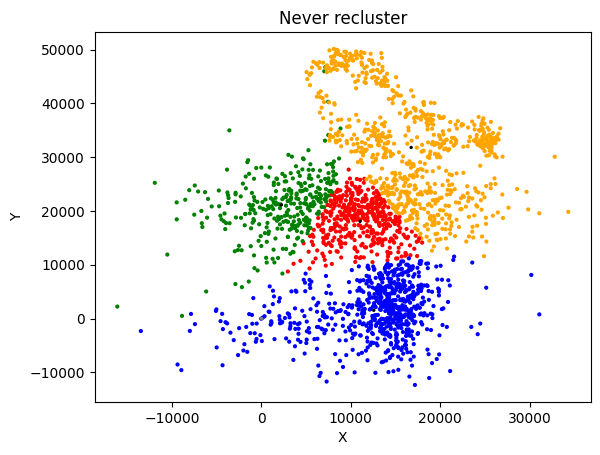

In [ ]:
# Add new points and never recluster
points = run_clustering_from_file(PLOT_NAME, CENTROIDS, COLOURS, show=False, save=False)
never_var = []

for index, point in enumerate(new_points_lst):
    points = add_point(point, points, save = False, show= False, reclustering=False)
    never_var.append(points.get_cluster_spread(COLOURS)[0]['total'])

save_scatter_plot(points, "Never Recluster")


Variance of Initial  28064971.2
Variance of Recluster:  51603693.2
Variance of Smart:  51709558.6
Variance of No Recluster:  68760642.6
Average match rate:  0.99714
Worst match rate:  0.97239


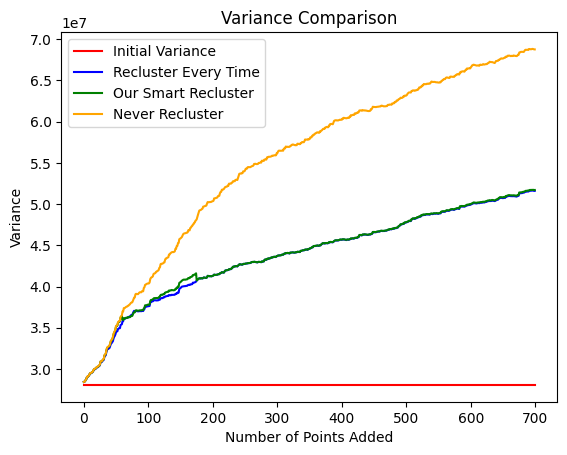

In [ ]:
# Graph
x_axis = range(len(never_var))
initial_var_line = [initial_var] * len(never_var)

plt.clf()
plt.plot(x_axis, initial_var_line, label="Initial Variance", color = 'r')
plt.plot(x_axis, recluster_var, label="Recluster Every Time", color = 'b')
plt.plot(x_axis, smart_var, label="Our Smart Recluster", color = 'g')
plt.plot(x_axis, never_var, label="Never Recluster", color = 'orange')

plt.title("Variance Comparison")
plt.xlabel("Number of Points Added")
plt.ylabel("Variance")

plt.legend()
plt.savefig("Variance Comparison.png")

# Variance
print(f"Variance of Initial {initial_var: .1f}")
print(f"Variance of Recluster: {recluster_var[len(recluster_var) - 1]: .1f}")
print(f"Variance of Smart: {smart_var[len(smart_var) - 1]: .1f}")
print(f"Variance of No Recluster: {never_var[len(never_var) - 1]: .1f}")

# Average match rate
match_rate_list = [1 - abs(bestVar - smart_var[i])/bestVar for i, bestVar in enumerate(recluster_var)]
avg_match_rate = sum(match_rate_list) / len(match_rate_list)
print(f"Average match rate: {avg_match_rate: .5f}")

# Worst match rate
wrst_match_rate = min(match_rate_list)
print(f"Worst match rate: {wrst_match_rate: .5f}")
